In [157]:
import networkx as nx
import random
from sklearn import metrics
from cdlib import algorithms
from cdlib import evaluation
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time
from scipy import stats
import os
from tqdm import tqdm as tqdm
import pickle

In [158]:
def duplex_network (G, l1, l2):
    
    G1 = G[l1].copy()
    G2 = G[l2].copy()
    
    ##delete common edges
    list_of_common_edges = []
    
    for e in G[l1].edges():
        if G[l2].has_edge(e[0], e[1]):
            list_of_common_edges.append([e[0], e[1]])
            
            
    print (len(list_of_common_edges))
    
    
    for e in list_of_common_edges:
        G1.remove_edge(e[0], e[1])
        G2.remove_edge(e[0], e[1])
        
    
    
    ##delete nodes with zero degree
    list_of_nodes = []
    for n in G1.nodes():
        if G1.degree(n)==0:
            list_of_nodes.append(n)
    for n in list_of_nodes:
        G1.remove_node(n)
        
    list_of_nodes = []
    for n in G2.nodes():
        if G2.degree(n)==0:
            list_of_nodes.append(n)
    for n in list_of_nodes:
        G2.remove_node(n)
            
    

    ##create union of nodes
    list_of_nodes = []
    for n in G1.nodes():
        list_of_nodes.append(n)
    for n in G2.nodes():
        list_of_nodes.append(n)
    for n in list_of_nodes:
        G1.add_node(n)
        G2.add_node(n)
        
        
        

    return G1, G2


#######

def partial_information (G1, G2, frac):
    
    
#     print ('# option = ', option)
    
    ##training/test sets
    Etest = {}
    Etrain = {}
    
    for e in G1.edges():
        if random.random() < frac:
            Etrain[e] = 1
        else:
            Etest[e] = 1
            
    for e in G2.edges():
        if random.random() < frac:
            Etrain[e] = 0
        else:
            Etest[e] = 0
        
        
    
    ##remnants
    rem_G1 = nx.Graph()
    rem_G2 = nx.Graph()
    for n in G1:
        rem_G1.add_node(n)
        rem_G2.add_node(n)
    for n in G2:
        rem_G1.add_node(n)
        rem_G2.add_node(n)
        
        
    
    for e in Etest:
        rem_G1.add_edge(e[0], e[1])
        rem_G2.add_edge(e[0], e[1])
            
    
    for e in Etrain:
        if Etrain[e] == 1:
            rem_G1.add_edge(e[0], e[1])
        if Etrain[e] == 0:
            rem_G2.add_edge(e[0], e[1])
    
    
    return rem_G1, rem_G2, Etest 


#####









def community_finder (G):
    
    C = algorithms.louvain(G)
#     C = algorithms.label_propagation(G)
    sigma = {}
    c = 0
    for r in C.communities:
        for q in r:
            sigma[q] = c
        c = c + 1
        
    mu = tot = 0.0
    for n in G.nodes():
        for m in G.neighbors(n):
            tot += 1.0
            if sigma[n] == sigma[m]:
                mu += 1.0
            
        
    return sigma, mu, tot





def classifier (rem_G1, rem_G2, Etest, TT = 0, show_log = False):
    
    ## degree/community
    if TT == 0:
        sigma1, mu1, tot1 = community_finder(rem_G1)
        sigma2, mu2, tot2 = community_finder(rem_G2)
        
        
        mu = 0.5
        if tot1 + tot2 > 0.0:
            mu = (mu1 + mu2) / (tot1 + tot2)


        
        classification, scores, ground_truth = [], [], []
        
        for e in Etest:
            
                
            n = e[0]
            m = e[1]
            
            s1 = rem_G1.degree(n)*rem_G1.degree(m)
            if sigma1[n] == sigma1[m]:
                s1 = s1 * mu
            else:
                s1 = s1 * (1.0-mu)
                
                
                
            s2 = rem_G2.degree(n)*rem_G2.degree(m)
            if sigma2[n] == sigma2[m]:
                s2 = s2 * mu
            else:
                s2 = s2 * (1.0-mu)
                
            
            t1 = t2 = 0.5
            if s1 + s2 > 0.0:
                t1 = s1 / (s1 + s2)
                t2 = s2 / (s1 + s2)
            
            
            s = random.randint(0,1)
            if t1 > t2:
                s = 1
            if t2 > t1:
                s = 0
                
            if show_log == True: 
                print (mu)
                print (rem_G1.degree(n), rem_G1.degree(m), t1)
                print (rem_G2.degree(n), rem_G2.degree(m), t2)
                print (Etest[e], '\n')
                
                
            
            scores.append(t1)
            classification.append(s)
            ground_truth.append(Etest[e])
            
                
    
        return classification, scores, ground_truth
    
    
    ## degree
    if TT == 1:
        
        classification, scores, ground_truth = [], [], []
        
        for e in Etest:
            
                
            n = e[0]
            m = e[1]
            
            s1 = rem_G1.degree(n)*rem_G1.degree(m)    
            s2 = rem_G2.degree(n)*rem_G2.degree(m)
            
            
            t1 = t2 = 0.5
            if s1 + s2 > 0.0:
                t1 = s1 / (s1 + s2)
                t2 = s2 / (s1 + s2)
            
            
            s = random.randint(0,1)
            if t1 > t2:
                s = 1
            if t2 > t1:
                s = 0
                   
            scores.append(t1)
            classification.append(s)
            ground_truth.append(Etest[e])
            
                
        return classification, scores, ground_truth
    
        
        
        
    ## community
    if TT == 2:
        sigma1, mu1, tot1 = community_finder(rem_G1)
        sigma2, mu2, tot2 = community_finder(rem_G2)
        
        mu = 0.5
        if tot1 + tot2 > 0.0:
            mu = (mu1 + mu2) / (tot1 + tot2)
        
        
        classification, scores, ground_truth = [], [], []
        
        for e in Etest:
            
                
            n = e[0]
            m = e[1]
            
            s1 = 1.0
            if sigma1[n] == sigma1[m]:
                s1 = s1 * mu
            else:
                s1 = s1 * (1.0-mu)
                
                
                
            s2 = 1.0
            if sigma2[n] == sigma2[m]:
                s2 = s2 * mu
            else:
                s2 = s2 * (1.0-mu)
                
            
            t1 = t2 = 0.5
            if s1 + s2 > 0.0:
                t1 = s1 / (s1 + s2)
                t2 = s2 / (s1 + s2)
            
            
            s = random.randint(0,1)
            if t1 > t2:
                s = 1
            if t2 > t1:
                s = 0
                
                
            
            scores.append(t1)
            classification.append(s)
            ground_truth.append(Etest[e])
            
                
    
        return classification, scores, ground_truth
    
        
        
    
####


def perform_analysis (G1, G2, step, TT = 0):
    
    
    #print ('# option = ', option)
    
    
    x , y, z  = [], [], []
    
    
    frac = 0.0
    while frac < 1.0:
        
        if frac <= 1.0 - step:
            
            print ('# %.2f ' %frac, ' %.2f' %(1.0 - step))
            
            rem_G1, rem_G2, Etest  = partial_information (G1, G2, frac)
            classification, scores, ground_truth = classifier (rem_G1, rem_G2, Etest, TT)
            acc = metrics.accuracy_score(ground_truth, classification)
            auc = metrics.roc_auc_score(ground_truth, scores)
            
            
            
            x.append(frac)
            y.append(acc)
            z.append(auc)
            
            
        frac += step
        
        
    results = [x, y, z]
    return results



## Figure 2a

In [323]:
def generate_power_law (gamma, kmin, kmax):
    
    xmin = np.power(kmin, 1.0 - gamma)
    xmax = np.power(kmax, 1.0 - gamma)
    x = xmax - random.random()*(xmax - xmin)
    x = np.power(x, 1.0 / (1.0 -gamma))
    return int(x)

######

def control_correlation (degree, prob):
    
    tmp_degree = []
    for i in range(len(degree)):
        tmp_degree.append(degree[i])
        
    for i in range(len(tmp_degree)):
        if random.random()<prob:
            n = tmp_degree[i]
            j = random.randint(0, len(degree)-1)
            tmp_degree[i] = tmp_degree[j]
            tmp_degree[j] = n
            
    return tmp_degree


#####


def generate_configuration_model (degree):
    
    edges = []
    for i in range(0, len(degree)):
        k = degree[i]
        for j in range(0, k):
            edges.append(i)
            
    ##random.shuffle(edges)
    for i in range(0, len(edges)):
        j = random.randint(0, len(edges)-1)
        tmp = edges[i]
        edges[i] = edges[j]
        edges[j] = tmp
    
    
    
    G = nx.Graph()
    for n in range(0, len(degree)):
        G.add_node(n)
        
    for i in range(0, len(edges)-1, 2):
        n = edges[i]
        m = edges[i+1]
        if G.has_edge(n, m) == False and n!=m:
            G.add_edge(n, m)
            
    return G
    

################
    
def generate_multiplex_configuration (N, gamma, kmin, kmax, prob, sign):
    
#     print ('# N = ', N)
#     print ('# gamma = ', gamma)
#     print ('# kmin = ', kmin)
#     print ('# kmax = ', kmax)
#     print ('# prob = ', prob)
#     print ('# sign = ' , sign)
    
    degree = []
    for i in range(0, N):
        degree.append(generate_power_law (gamma, kmin, kmax))
    degree = sorted(degree)
    tmp_degree = []
    for i in range (0, len(degree)):
        if sign > 0:
            tmp_degree.append(degree[i])
        if sign < 0:
            tmp_degree.append(degree[len(degree)-i-1])
            
    
    ###
    tmp_degree = control_correlation (tmp_degree, prob)
    ###
    
    G = {}
    G[1] = generate_configuration_model (degree)
    G[2] = generate_configuration_model (tmp_degree)
    
    
    ###
    
    return G
    
    
#########

In [324]:
N = 100000
kmin = 3
sign = 1
prob = 1.0
step = 0.1

results = {}

In [325]:
gamma = 2.1
kmax = int(np.sqrt(N))
G = generate_multiplex_configuration (N, gamma, kmin, kmax, prob, sign)
l1 = 1
l2 = 2
G1, G2 = duplex_network (G, l1, l2)

results[gamma] = perform_analysis (G1, G2, step, TT=1)

85
# 0.00   0.90
# 0.10   0.90
# 0.20   0.90
# 0.30   0.90
# 0.40   0.90
# 0.50   0.90
# 0.60   0.90
# 0.70   0.90
# 0.80   0.90
# 0.90   0.90


In [326]:
gamma = 2.5
kmax = int(np.sqrt(N))
G = generate_multiplex_configuration (N, gamma, kmin, kmax, prob, sign)
l1 = 1
l2 = 2
G1, G2 = duplex_network (G, l1, l2)

results[gamma] = perform_analysis (G1, G2, step, TT=1)

28
# 0.00   0.90
# 0.10   0.90
# 0.20   0.90
# 0.30   0.90
# 0.40   0.90
# 0.50   0.90
# 0.60   0.90
# 0.70   0.90
# 0.80   0.90
# 0.90   0.90


In [327]:
gamma = 2.9
kmax = int(np.sqrt(N))
G = generate_multiplex_configuration (N, gamma, kmin, kmax, prob, sign)
l1 = 1
l2 = 2
G1, G2 = duplex_network (G, l1, l2)

results[gamma] = perform_analysis (G1, G2, step, TT=1)

20
# 0.00   0.90
# 0.10   0.90
# 0.20   0.90
# 0.30   0.90
# 0.40   0.90
# 0.50   0.90
# 0.60   0.90
# 0.70   0.90
# 0.80   0.90
# 0.90   0.90


In [328]:
gamma = 3.5
kmax = int(np.power(N, 1.0/(gamma-1.0)))
G = generate_multiplex_configuration (N, gamma, kmin, kmax, prob, sign)
l1 = 1
l2 = 2
G1, G2 = duplex_network (G, l1, l2)

results[gamma] = perform_analysis (G1, G2, step, TT=1)

18
# 0.00   0.90
# 0.10   0.90
# 0.20   0.90
# 0.30   0.90
# 0.40   0.90
# 0.50   0.90
# 0.60   0.90
# 0.70   0.90
# 0.80   0.90
# 0.90   0.90


In [329]:
with open('figure2a_data.pk', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [330]:
with open('figure2a_data.pk', 'rb') as handle:
    results = pickle.load(handle)

(0.0, 1)

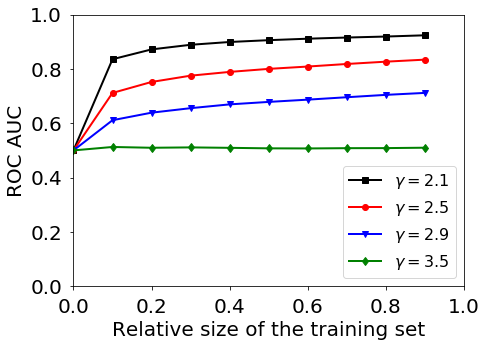

In [331]:
fig = plt.figure()
fig.set_size_inches(7,5)
plt.rc('text', usetex=False)
plt.rc('font', size=20, **{'family':'DejaVu Sans','sans-serif':['Helvetica']})
plt.rcParams['xtick.major.pad'] = 8
plt.rcParams['ytick.major.pad'] = 8

gamma = 2.1
plt.plot(results[gamma][0], results[gamma][2], marker='s', linewidth=2, color = 'black', label='$\gamma = 2.1$')

gamma = 2.5
plt.plot(results[gamma][0], results[gamma][2], marker='o', linewidth=2, color = 'red', label='$\gamma = 2.5$')


gamma = 2.9
plt.plot(results[gamma][0], results[gamma][2], marker='v', linewidth=2, color = 'blue', label='$\gamma = 2.9$')


gamma = 3.5
plt.plot(results[gamma][0], results[gamma][2], marker='d', linewidth=2, color = 'green', label='$\gamma = 3.5$')




plt.legend(loc='lower right', fontsize = 16)
plt.xlabel('Relative size of the training set')
plt.ylabel('ROC AUC')
plt.ylim(.0,1)
plt.xlim(.0,1)

## Figure 2b

In [21]:
def LFR(n,t1,t2,mu,avg_k,max_k):
    #function to generate LFR network as a networkx object and obtain community assignments
    N,Mu,T1,T2,maxk,k=str(n),str(mu),str(t1),str(t2),str(max_k),str(avg_k)
    s='./benchmark -N '+N+' -mu '+Mu+ ' -maxk ' +maxk  + ' -k '+k  +' -t1 ' +T1+' -t2 ' +T2
    os.system(s)
    
    x=np.loadtxt('network.dat')
    edges=[(int(x[i][0])-1,int(x[i][1])-1) for i in range(len(x))]
    g=nx.Graph(edges)
    
    x=np.loadtxt('community.dat')
    coms={int(x[i][0])-1:int(x[i][1]) for i in range(len(x))}
    #nx.set_node_attributes(g,coms,name='community')
    
    return g, coms




def lfr_multiplex (N, tau1, tau2, mu, average_degree, max_degree, min_community, prob_relabel):

                
    #############################        
            
    H, comm = LFR(n=N, t1=tau1, t2=tau2, mu=mu, avg_k=average_degree, max_k = max_degree)   
    groups = {}
    for n in comm:
        c = comm[n]
        if c not in groups:
            groups[c] = []
        groups[c].append(n)
        
   #############################   

    sigma1 = {}
    for n in comm:
        sigma1[n] = comm[n]

   #########
        
    
    new_labels = {}
    for C in groups:
        tmp = groups[C].copy()
        random.shuffle(tmp)
        for i in range(0, len(groups[C])):
            n = groups[C][i]
            m = tmp[i]
            new_labels[n] = m
    ###########################################  
    
    tmp_sigma2 = {}
    for n in sigma1:
        m = new_labels[n]
        tmp_sigma2[m] = sigma1[n]
        
    ###########################################
    
    
    
    
    G = {}
    G[1] = H.copy()
    G[2] = nx.Graph()
    for n in G[1]:
        G[2].add_node(n)
    for e in G[1].edges():
        n = new_labels[e[0]]
        m = new_labels[e[1]]
        G[2].add_edge(n, m)
    ############################################
    
    
    
    
    
    
    #############################################
    ## break community correlation
    
    list_nodes = list(G[2].nodes())
    new_labels = {}
    H = G[2].copy()
    for n in G[2]:
        new_labels[n] = n
    for n in new_labels:
        if random.random()<prob_relabel:
            m = random.choice(list_nodes)
            tmp = new_labels[n]
            new_labels[n] = new_labels[m]
            new_labels[m] = tmp
            
    G[2] = nx.Graph()
    for n in H:
        m = new_labels[n]
        G[2].add_node(m)
    for e in H.edges():
        n = new_labels[e[0]]
        m = new_labels[e[1]]
        G[2].add_edge(n, m)
    ##############################################
    
    
    sigma2 = {}
    for n in tmp_sigma2:
        m = new_labels[n]
        sigma2[m] = tmp_sigma2[n]
    
    
    
#     print(len(G[1].edges()))
#     print(len(G[2].edges()))
    
    
    
    return G, sigma1, sigma2, mu




In [222]:
N = 10000
tau2 = 1.0
mu = 0.1
average_degree = 5.0
min_community = 1
prob = 1.0


results_lfr = {}

In [223]:
gamma = 2.1
max_degree = int(np.sqrt(N))


G, sigma1, sigma2, mu_tmp = lfr_multiplex (N, gamma, tau2, mu, average_degree, max_degree, min_community, prob)
l1 = 1
l2 = 2
G1, G2 = duplex_network (G, l1, l2)

results_lfr[gamma] = perform_analysis (G1, G2, step, TT=0)

18
# 0.00   0.90
# 0.10   0.90
# 0.20   0.90
# 0.30   0.90
# 0.40   0.90
# 0.50   0.90
# 0.60   0.90
# 0.70   0.90
# 0.80   0.90
# 0.90   0.90


In [224]:
gamma = 2.5
max_degree = int(np.sqrt(N))


G, sigma1, sigma2, mu_tmp = lfr_multiplex (N, gamma, tau2, mu, average_degree, max_degree, min_community, prob)
l1 = 1
l2 = 2
G1, G2 = duplex_network (G, l1, l2)

results_lfr[gamma] = perform_analysis (G1, G2, step, TT=0)

6
# 0.00   0.90
# 0.10   0.90
# 0.20   0.90
# 0.30   0.90
# 0.40   0.90
# 0.50   0.90
# 0.60   0.90
# 0.70   0.90
# 0.80   0.90
# 0.90   0.90


In [225]:
gamma = 2.9
max_degree = int(np.sqrt(N))


G, sigma1, sigma2, mu_tmp = lfr_multiplex (N, gamma, tau2, mu, average_degree, max_degree, min_community, prob)
l1 = 1
l2 = 2
G1, G2 = duplex_network (G, l1, l2)

results_lfr[gamma] = perform_analysis (G1, G2, step, TT=0)

18
# 0.00   0.90
# 0.10   0.90
# 0.20   0.90
# 0.30   0.90
# 0.40   0.90
# 0.50   0.90
# 0.60   0.90
# 0.70   0.90
# 0.80   0.90
# 0.90   0.90


In [226]:
gamma = 3.5
kmax = int(np.power(N, 1.0/(gamma-1.0)))


G, sigma1, sigma2, mu_tmp = lfr_multiplex (N, gamma, tau2, mu, average_degree, max_degree, min_community, prob)
l1 = 1
l2 = 2
G1, G2 = duplex_network (G, l1, l2)

results_lfr[gamma] = perform_analysis (G1, G2, step, TT=0)

11
# 0.00   0.90
# 0.10   0.90
# 0.20   0.90
# 0.30   0.90
# 0.40   0.90
# 0.50   0.90
# 0.60   0.90
# 0.70   0.90
# 0.80   0.90
# 0.90   0.90


In [227]:
with open('figure2b_data.pk', 'wb') as handle:
    pickle.dump(results_lfr, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [228]:
with open('figure2b_data.pk', 'rb') as handle:
    results_lfr = pickle.load(handle)

(0.0, 1)

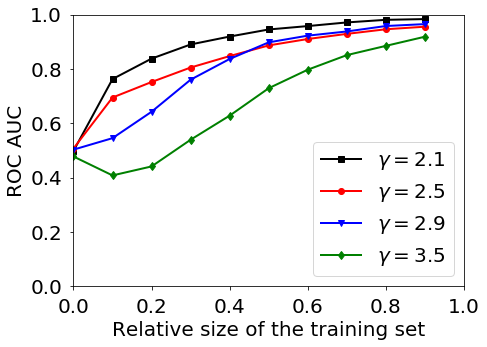

In [229]:
fig = plt.figure()
fig.set_size_inches(7,5)
plt.rc('text', usetex=False)
plt.rc('font', size=20, **{'family':'DejaVu Sans','sans-serif':['Helvetica']})
plt.rcParams['xtick.major.pad'] = 8
plt.rcParams['ytick.major.pad'] = 8

gamma = 2.1
plt.plot(results_lfr[gamma][0], results_lfr[gamma][2], marker='s', linewidth=2, color = 'black', label='$\gamma = 2.1$')

gamma = 2.5
plt.plot(results_lfr[gamma][0], results_lfr[gamma][2], marker='o', linewidth=2, color = 'red', label='$\gamma = 2.5$')

gamma = 2.9
plt.plot(results_lfr[gamma][0], results_lfr[gamma][2], marker='v', linewidth=2, color = 'blue', label='$\gamma = 2.9$')


gamma = 3.5
plt.plot(results_lfr[gamma][0], results_lfr[gamma][2], marker='d', linewidth=2, color = 'green', label='$\gamma = 3.5$')





plt.legend(loc='lower right')
plt.xlabel('Relative size of the training set')
plt.ylabel('ROC AUC')
plt.ylim(.0,1)
plt.xlim(.0,1)

## Figure 2c

In [190]:
N = 10000
tau2 = 1.0
gamma = 2.1
max_degree = int(np.sqrt(N))
average_degree = 5.0
min_community = 1
prob = 1.0


results_lfr = {}

In [191]:
mu = 0.1

G, sigma1, sigma2, mu_tmp = lfr_multiplex (N, gamma, tau2, mu, average_degree, max_degree, min_community, prob)
l1 = 1
l2 = 2
G1, G2 = duplex_network (G, l1, l2)

results_lfr[mu] = perform_analysis (G1, G2, step, TT=0)

11
# 0.00   0.90
# 0.10   0.90
# 0.20   0.90
# 0.30   0.90
# 0.40   0.90
# 0.50   0.90
# 0.60   0.90
# 0.70   0.90
# 0.80   0.90
# 0.90   0.90


In [192]:
mu = 0.2

G, sigma1, sigma2, mu_tmp = lfr_multiplex (N, gamma, tau2, mu, average_degree, max_degree, min_community, prob)
l1 = 1
l2 = 2
G1, G2 = duplex_network (G, l1, l2)

results_lfr[mu] = perform_analysis (G1, G2, step, TT=0)

19
# 0.00   0.90
# 0.10   0.90
# 0.20   0.90
# 0.30   0.90
# 0.40   0.90
# 0.50   0.90
# 0.60   0.90
# 0.70   0.90
# 0.80   0.90
# 0.90   0.90


In [193]:
mu = 0.3

G, sigma1, sigma2, mu_tmp = lfr_multiplex (N, gamma, tau2, mu, average_degree, max_degree, min_community, prob)
l1 = 1
l2 = 2
G1, G2 = duplex_network (G, l1, l2)

results_lfr[mu] = perform_analysis (G1, G2, step, TT=0)

15
# 0.00   0.90
# 0.10   0.90
# 0.20   0.90
# 0.30   0.90
# 0.40   0.90
# 0.50   0.90
# 0.60   0.90
# 0.70   0.90
# 0.80   0.90
# 0.90   0.90


In [194]:
mu = 0.4

G, sigma1, sigma2, mu_tmp = lfr_multiplex (N, gamma, tau2, mu, average_degree, max_degree, min_community, prob)
l1 = 1
l2 = 2
G1, G2 = duplex_network (G, l1, l2)

results_lfr[mu] = perform_analysis (G1, G2, step, TT=0)

18
# 0.00   0.90
# 0.10   0.90
# 0.20   0.90
# 0.30   0.90
# 0.40   0.90
# 0.50   0.90
# 0.60   0.90
# 0.70   0.90
# 0.80   0.90
# 0.90   0.90


In [195]:
mu = 0.5

G, sigma1, sigma2, mu_tmp = lfr_multiplex (N, gamma, tau2, mu, average_degree, max_degree, min_community, prob)
l1 = 1
l2 = 2
G1, G2 = duplex_network (G, l1, l2)

results_lfr[mu] = perform_analysis (G1, G2, step, TT=0)

21
# 0.00   0.90
# 0.10   0.90
# 0.20   0.90
# 0.30   0.90
# 0.40   0.90
# 0.50   0.90
# 0.60   0.90
# 0.70   0.90
# 0.80   0.90
# 0.90   0.90


In [197]:
# mu = 0.6

# G, sigma1, sigma2, mu_tmp = lfr_multiplex (N, gamma, tau2, mu, average_degree, max_degree, min_community, prob)
# l1 = 1
# l2 = 2
# G1, G2 = duplex_network (G, l1, l2)

# results_lfr[mu] = perform_analysis (G1, G2, step, TT=0)

In [198]:
with open('figure2c_data.pk', 'wb') as handle:
    pickle.dump(results_lfr, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [199]:
with open('figure2c_data.pk', 'rb') as handle:
    results_lfr = pickle.load(handle)

(0.0, 1)

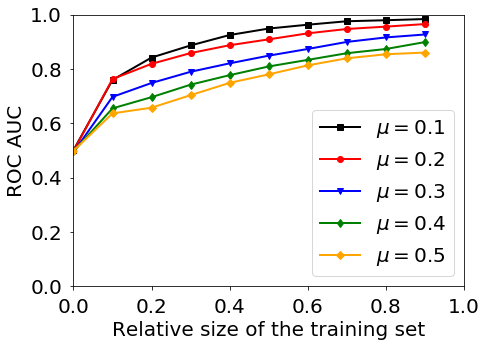

In [200]:
fig = plt.figure()
fig.set_size_inches(7,5)
plt.rc('text', usetex=False)
plt.rc('font', size=20, **{'family':'DejaVu Sans','sans-serif':['Helvetica']})
plt.rcParams['xtick.major.pad'] = 8
plt.rcParams['ytick.major.pad'] = 8

mu = 0.1
plt.plot(results_lfr[mu][0], results_lfr[mu][2], marker='s', linewidth=2, color = 'black', label='$\mu = 0.1$')

mu = 0.2
plt.plot(results_lfr[mu][0], results_lfr[mu][2], marker='o', linewidth=2, color = 'red', label='$\mu = 0.2$')


mu = 0.3
plt.plot(results_lfr[mu][0], results_lfr[mu][2], marker='v', linewidth=2, color = 'blue', label='$\mu = 0.3$')


mu = 0.4
plt.plot(results_lfr[mu][0], results_lfr[mu][2], marker='d', linewidth=2, color = 'green', label='$\mu = 0.4$')


mu = 0.5
plt.plot(results_lfr[mu][0], results_lfr[mu][2], marker='D', linewidth=2, color = 'orange', label='$\mu = 0.5$')


# mu = 0.6
# plt.plot(results_lfr[mu][0], results_lfr[mu][2], marker='D', linewidth=2, color = 'orange', label='$\mu = 0.6$')



plt.legend(loc='lower right')
plt.xlabel('Relative size of the training set')
plt.ylabel('ROC AUC')
plt.ylim(.0,1)
plt.xlim(.0,1)

# Wu et al. method

In [290]:
#######

def partial_information_wu_et_al (G1, G2, frac):
    
    
#     print ('# option = ', option)
    
    ##training/test sets
    Etest = {}
    Etrain = {}
    
    for e in G1.edges():
        if random.random() < frac:
            Etrain[e] = 1
        else:
            Etest[e] = 1
            
    for e in G2.edges():
        if random.random() < frac:
            Etrain[e] = 0
        else:
            Etest[e] = 0

    
    
    return Etrain, Etest 


#####



def wu_et_al_classifier_final (Etrain, Etest, max_iter, tol, show_log = False):
    
    

     
    ################################
    Q = {}
    for e in Etest:
        n = e[0]
        m = e[1]
        Q[e] = 0.5
    ################################
    
    
    
    #######################################
    ##partial observation of layers 1 and 2
    obs_degree1 = {}
    obs_degree2 = {}
    
    
    
    for e in Etest:
        n = e[0]
        m = e[1]
        if n not in obs_degree1:
            obs_degree1[n] = 0
            obs_degree2[n] = 0
        if m not in obs_degree1:
            obs_degree1[m] = 0
            obs_degree2[m] = 0
            
    for e in Etrain:
        n = e[0]
        m = e[1]
        if n not in obs_degree1:
            obs_degree1[n] = 0
            obs_degree2[n] = 0
        if m not in obs_degree1:
            obs_degree1[m] = 0
            obs_degree2[m] = 0
            
        if Etrain[e] == 1:
            obs_degree1[n] += 1
            obs_degree1[m] += 1
        else:
            obs_degree2[n] += 1
            obs_degree2[m] += 1
    #######################################

    
   
    
    
        
        
    iteration = 0
    max_err = tol + 1
    while iteration < max_iter:
        
        
        #######################################
        ##update degree sequences
        degree1, degree2 = {}, {}
        for n in obs_degree1:
            degree1[n] = obs_degree1[n]
        for n in obs_degree2:
            degree2[n] = obs_degree2[n]
        for e in Q:
            n = e[0]
            m = e[1]
#             if n not in degree1:
#                 degree1[n] = 0.0
#                 degree2[n] = 0.0
#             if m not in degree1:
#                 degree1[m] = 0.0
#                 degree2[m] = 0.0
            degree1[n] += Q[e]
            degree1[m] += Q[e]
            degree2[n] += 1.0 - Q[e]
            degree2[m] += 1.0 - Q[e]
        #######################################

        max_err = 0.0
        #######################################
        ##update probabilities
        for e in Etest:
            n = e[0]
            m = e[1]
                
            old = Q[e]
            Q[e] = degree1[n]*degree1[m] / (degree1[n]*degree1[m] + degree2[n]*degree2[m])
            
            err = abs(old-Q[e])
            if err > max_err:
                max_err = err
        #######################################
                
                
#         print ('iter = ', iteration, ' max_err = ', max_err)
        iteration += 1
        if max_err < tol:
            print ('iter = ', iteration, ' max_err = ', max_err)
            iteration = max_iter + 1
            
   


    
    print ('iter = ', iteration, ' max_err = ', max_err)
    
        
    ########  
    classification, scores, ground_truth = [], [], []
        
    for e in Etest:


        n = e[0]
        m = e[1]

        s1 = Q[e]
        s2 = 1.0 - Q[e]
        
        

        t1 = t2 = 0.5
        if s1 + s2 > 0.0:
            t1 = s1 / (s1 + s2)
            t2 = s2 / (s1 + s2)


        s = random.randint(0,1)
        if t1 > t2:
            s = 1
        if t2 > t1:
            s = 0

    
        scores.append(t1)
        classification.append(s)
        ground_truth.append(Etest[e])



    return classification, scores, ground_truth


#################






########################


def perform_analysis_wu_et_al (G1, G2, step):
    
    
    #print ('# option = ', option)
    
    
    x , y, z  = [], [], []
    
    max_iter = 10000
    tol = 1e-3
    
    
    frac = 0.0
    while frac < 1.0:
        
        if frac <= 1.0 - step:
            
            print ('# %.2f ' %frac, ' %.2f' %(1.0 - step))
            
            Etrain, Etest  = partial_information_wu_et_al (G1, G2, frac)
            classification, scores, ground_truth = wu_et_al_classifier_final (Etrain, Etest, max_iter, tol, show_log = True)
            acc = metrics.accuracy_score(ground_truth, classification)
            auc = metrics.roc_auc_score(ground_truth, scores)
            
            
            
            x.append(frac)
            y.append(acc)
            z.append(auc)
            
            
        frac += step
        
    results = [x, y, z]
    return results







## Figure 3d

In [270]:
N = 10000
tau2 = 1.0
gamma = 2.1
max_degree = int(np.sqrt(N))
average_degree = 5.0
min_community = 1
prob = 1.0
mu = 0.1
step = 0.1


results_lfr = {}

In [271]:
G, sigma1, sigma2, mu_tmp = lfr_multiplex (N, gamma, tau2, mu, average_degree, max_degree, min_community, prob)
l1 = 1
l2 = 2
G1, G2 = duplex_network (G, l1, l2)

6


In [272]:
results_lfr['DC'] = perform_analysis (G1, G2, step, TT=0)

# 0.00   0.90
# 0.10   0.90
# 0.20   0.90
# 0.30   0.90
# 0.40   0.90
# 0.50   0.90
# 0.60   0.90
# 0.70   0.90
# 0.80   0.90
# 0.90   0.90


In [273]:
results_lfr['C'] = perform_analysis (G1, G2, step, TT=2)

# 0.00   0.90
# 0.10   0.90
# 0.20   0.90
# 0.30   0.90
# 0.40   0.90
# 0.50   0.90
# 0.60   0.90
# 0.70   0.90
# 0.80   0.90
# 0.90   0.90


In [274]:
results_lfr['D'] = perform_analysis (G1, G2, step, TT=1)

# 0.00   0.90
# 0.10   0.90
# 0.20   0.90
# 0.30   0.90
# 0.40   0.90
# 0.50   0.90
# 0.60   0.90
# 0.70   0.90
# 0.80   0.90
# 0.90   0.90


In [291]:
results_lfr['Wu'] = perform_analysis_wu_et_al (G1, G2, step)

# 0.00   0.90
iter =  1  max_err =  0.0
iter =  10001  max_err =  0.0
# 0.10   0.90
iter =  203  max_err =  0.0005053468010930429
iter =  10001  max_err =  0.0005053468010930429
# 0.20   0.90
iter =  687  max_err =  0.000849327135661937
iter =  10001  max_err =  0.000849327135661937
# 0.30   0.90
iter =  667  max_err =  0.0009998529670437462
iter =  10001  max_err =  0.0009998529670437462
# 0.40   0.90
iter =  422  max_err =  0.0009770675367143378
iter =  10001  max_err =  0.0009770675367143378
# 0.50   0.90
iter =  327  max_err =  0.0009877608039872143
iter =  10001  max_err =  0.0009877608039872143
# 0.60   0.90
iter =  144  max_err =  0.000970765203546331
iter =  10001  max_err =  0.000970765203546331
# 0.70   0.90
iter =  145  max_err =  0.0009894860177477316
iter =  10001  max_err =  0.0009894860177477316
# 0.80   0.90
iter =  65  max_err =  0.0009712759346524602
iter =  10001  max_err =  0.0009712759346524602
# 0.90   0.90
iter =  60  max_err =  0.0009776725203456405
iter =  1000

In [292]:
with open('figure2d_data.pk', 'wb') as handle:
    pickle.dump(results_lfr, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [293]:
with open('figure2d_data.pk', 'rb') as handle:
    results_lfr = pickle.load(handle)

(0.0, 1)

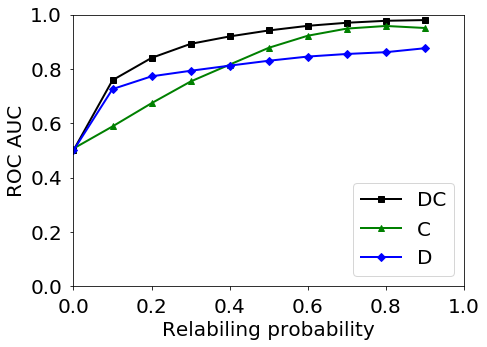

In [309]:
fig = plt.figure()
fig.set_size_inches(7,5)
plt.rc('text', usetex=False)
plt.rc('font', size=20, **{'family':'DejaVu Sans','sans-serif':['Helvetica']})
plt.rcParams['xtick.major.pad'] = 8
plt.rcParams['ytick.major.pad'] = 8


plt.plot(results_lfr['DC'][0], results_lfr['DC'][2], marker='s', linewidth=2, color = 'black', label='DC')
plt.plot(results_lfr['C'][0], results_lfr['C'][2], marker='^', linewidth=2, color = 'green', label='C')
plt.plot(results_lfr['D'][0], results_lfr['D'][2], marker='D', linewidth=2, color = 'blue', label='D')

#plt.plot(results_lfr['Wu'][0], results_lfr['Wu'][2], marker='o', linewidth=2, color = 'red', label='Wu et al.')


plt.legend(loc='lower right')
plt.xlabel('Relabiling probability')
plt.ylabel('ROC AUC')
plt.ylim(.0,1)
plt.xlim(.0,1)

## Figure 2d

In [314]:
N = 10000
gamma = 2.1
kmax = int(np.sqrt(N))
kmin = 3
sign = 1
prob = 1.0
step = 0.1


results = {}

In [315]:
G = generate_multiplex_configuration (N, gamma, kmin, kmax, prob, sign)
l1 = 1
l2 = 2
G1, G2 = duplex_network (G, l1, l2)

45


In [316]:
results['DC'] = perform_analysis (G1, G2, step, TT=0)

# 0.00   0.90
# 0.10   0.90
# 0.20   0.90
# 0.30   0.90
# 0.40   0.90
# 0.50   0.90
# 0.60   0.90
# 0.70   0.90
# 0.80   0.90
# 0.90   0.90


In [317]:
results['C'] = perform_analysis (G1, G2, step, TT=2)

# 0.00   0.90
# 0.10   0.90
# 0.20   0.90
# 0.30   0.90
# 0.40   0.90
# 0.50   0.90
# 0.60   0.90
# 0.70   0.90
# 0.80   0.90
# 0.90   0.90


In [318]:
results['D'] = perform_analysis (G1, G2, step, TT=1)

# 0.00   0.90
# 0.10   0.90
# 0.20   0.90
# 0.30   0.90
# 0.40   0.90
# 0.50   0.90
# 0.60   0.90
# 0.70   0.90
# 0.80   0.90
# 0.90   0.90


In [319]:
results['Wu'] = perform_analysis_wu_et_al (G1, G2, step)

# 0.00   0.90
iter =  1  max_err =  0.0
iter =  10001  max_err =  0.0
# 0.10   0.90
iter =  54  max_err =  0.0007922679511980007
iter =  10001  max_err =  0.0007922679511980007
# 0.20   0.90
iter =  97  max_err =  0.00042413695664698936
iter =  10001  max_err =  0.00042413695664698936
# 0.30   0.90
iter =  1047  max_err =  0.0008927382154509944
iter =  10001  max_err =  0.0008927382154509944
# 0.40   0.90
iter =  163  max_err =  0.000995612861532158
iter =  10001  max_err =  0.000995612861532158
# 0.50   0.90
iter =  146  max_err =  0.0009871402832163437
iter =  10001  max_err =  0.0009871402832163437
# 0.60   0.90
iter =  186  max_err =  0.0009933167497825426
iter =  10001  max_err =  0.0009933167497825426
# 0.70   0.90
iter =  59  max_err =  0.0009723823487092186
iter =  10001  max_err =  0.0009723823487092186
# 0.80   0.90
iter =  62  max_err =  0.000989678336897809
iter =  10001  max_err =  0.000989678336897809
# 0.90   0.90
iter =  30  max_err =  0.0008947054927349596
iter =  1000

In [320]:
with open('figure2dbis_data.pk', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [321]:
with open('figure2dbis_data.pk', 'rb') as handle:
    results = pickle.load(handle)

(0.0, 1)

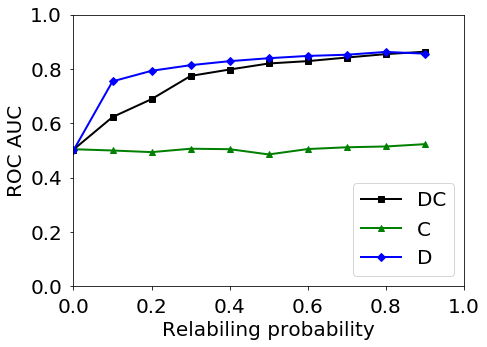

In [322]:
fig = plt.figure()
fig.set_size_inches(7,5)
plt.rc('text', usetex=False)
plt.rc('font', size=20, **{'family':'DejaVu Sans','sans-serif':['Helvetica']})
plt.rcParams['xtick.major.pad'] = 8
plt.rcParams['ytick.major.pad'] = 8


plt.plot(results['DC'][0], results['DC'][2], marker='s', linewidth=2, color = 'black', label='DC')
plt.plot(results['C'][0], results['C'][2], marker='^', linewidth=2, color = 'green', label='C')
plt.plot(results['D'][0], results['D'][2], marker='D', linewidth=2, color = 'blue', label='D')

#plt.plot(results['Wu'][0], results['Wu'][2], marker='o', linewidth=2, color = 'red', label='Wu et al.')


plt.legend(loc='lower right')
plt.xlabel('Relabiling probability')
plt.ylabel('ROC AUC')
plt.ylim(.0,1)
plt.xlim(.0,1)